In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import multiprocess as mp
import numpy as np
import pandas as pd
import bioframe
import cooltools
import cooler
import re
import bbi
from pybedtools import bedtool
import pybedtools
import pyranges
from matplotlib.gridspec import GridSpec
from cooltools import snipping
import scipy


In [2]:
mm10 = bioframe.fetch_chromsizes('mm10')
chromsizes = bioframe.fetch_chromsizes('mm10')
chromosomes = list(chromsizes.index)


In [3]:
#naming, in this case 1Mb resolution coolers
filepath_dmso_ND='/nl/umw_job_dekker/users/as38w/JZ2022_git/coolers/JZ-MEF-AsiS1-ND-dmso6h-HiCD2R1.mm10.nodups.65M.1000.mcool::resolutions/1000000'
filepath_dmso_4OHT='/nl/umw_job_dekker/users/as38w/JZ2022_git/coolers/JZ-MEF-AsiS1-4OHT-dmso6h-HiCD2R1.mm10.nodups.65M.1000.mcool::resolutions/1000000'

c_dmso_ND = cooler.Cooler(filepath_dmso_ND)
c_dmso_4OHT = cooler.Cooler(filepath_dmso_4OHT)


In [4]:
#fetch matrix
##for JZ 4C plot == chr2:3000000-182113224
resolution = c_dmso_ND.binsize
mat_dmso_ND = c_dmso_ND.matrix(balance=True).fetch('chr2:3000000-182113224')
mat_dmso_4OHT = c_dmso_4OHT.matrix(balance=True).fetch('chr2:3000000-182113224')


In [6]:
#Generate expected file if needing to normalise: 
## "cooltools compute-expected -t cis" 
    #default cis

exp_dmso_ND=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ2022_git/coolers/JZ-MEF-AsiS1-ND-dmso6h-HiCD2R1.mm10.1000000.cis.expected', sep="\t")
exp_dmso_ND=exp_dmso_ND[exp_dmso_ND['chrom']=="chr2"]
exp_dmso_ND=exp_dmso_ND[exp_dmso_ND['diag']>=3]

exp_dmso_4OHT=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ2022_git/coolers/JZ-MEF-AsiS1-4OHT-dmso6h-HiCD2R1.mm10.1000000.cis.expected', sep="\t")
exp_dmso_4OHT=exp_dmso_4OHT[exp_dmso_4OHT['chrom']=="chr2"]
exp_dmso_4OHT=exp_dmso_4OHT[exp_dmso_4OHT['diag']>=3]

exp_dmso_4OHT.head()


,chrom,diag,n_valid,count.sum,balanced.sum,count.avg,balanced.avg
199,chr2,3,170,56369.0,2.038206,331.582353,0.011989
200,chr2,4,169,36096.0,1.264477,213.585799,0.007482
201,chr2,5,169,28605.0,0.972222,169.260355,0.005753
202,chr2,6,169,23068.0,0.784912,136.497041,0.004644
203,chr2,7,169,23555.0,0.766754,139.378698,0.004537


In [7]:
#for cis expected (in trans is a scalar)
from numpy import concatenate, zeros
from scipy.linalg import toeplitz

exp_dmso_ND_np=exp_dmso_ND['balanced.avg'].to_numpy()
exp_dmso_4OHT_np=exp_dmso_4OHT['balanced.avg'].to_numpy()

mat_exp_dmso_ND_np=toeplitz(exp_dmso_ND_np)
mat_exp_dmso_4OHT_np=toeplitz(exp_dmso_4OHT_np)

mat_exp_dmso_ND_np


array([[0.01201999, 0.00794576, 0.0062668 , ...,        nan,        nan,
               nan],
       [0.00794576, 0.01201999, 0.00794576, ...,        nan,        nan,
               nan],
       [0.0062668 , 0.00794576, 0.01201999, ..., 0.00062935,        nan,
               nan],
       ...,
       [       nan,        nan, 0.00062935, ..., 0.01201999, 0.00794576,
        0.0062668 ],
       [       nan,        nan,        nan, ..., 0.00794576, 0.01201999,
        0.00794576],
       [       nan,        nan,        nan, ..., 0.0062668 , 0.00794576,
        0.01201999]])

In [8]:
#observed/expected matrix
mat_dmso_ND_oe=np.divide(mat_dmso_ND,mat_exp_dmso_ND_np)
mat_dmso_ND_oe=np.nan_to_num(mat_dmso_ND_oe)
mat_dmso_4OHT_oe=np.divide(mat_dmso_4OHT,mat_exp_dmso_4OHT_np)
mat_dmso_4OHT_oe=np.nan_to_num(mat_dmso_4OHT_oe)

mat_dmso_ND_oe


array([[30.5964503 , 13.10259108,  2.64388544, ...,  0.        ,
         0.        ,  0.        ],
       [13.10259108, 28.82783656,  7.30212341, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.64388544,  7.30212341, 33.08109624, ...,  1.14046243,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  1.14046243, ..., 30.3832181 ,
         9.120744  ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  9.120744  ,
        22.98029782,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [9]:
mat_dmso_4OHT_oe.shape

(180, 180)

In [12]:
#non-elegant way to call chrom positions ... fix at some point
##use cooler binnify to make binned genome coordinates and slice according to the matrix fetched
bins=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ2022_git/coolers/mm10bins_1000000',sep='\t',names=['chrom','start','end'])
bins=bins[bins['chrom']=='chr2']
bins=bins[bins['start']>=3000000]
bins.reset_index(inplace=True)
bins.head()


,index,chrom,start,end
0,199,chr2,3000000,4000000
1,200,chr2,4000000,5000000
2,201,chr2,5000000,6000000
3,202,chr2,6000000,7000000
4,203,chr2,7000000,8000000


In [13]:
from pandas import Series
from numpy.random import randn

#In this case anchor was 13-14Mb for chr2 starting at 3Mb == [10:11]

##Observed
ND_O=mat_dmso_ND[10:11, :]
rowsND_O = pd.DataFrame(ND_O).transpose()
rowsND_O.columns=['obsv']

foht_O=mat_dmso_4OHT[10:11, :]
rowsfoht_O = pd.DataFrame(foht_O).transpose()
rowsfoht_O.columns=['obsv']

##Obs/Exp
ND=mat_dmso_ND_oe[10:11, :]
rowsND = pd.DataFrame(ND).transpose()
rowsND.columns=['OvE']

foht=mat_dmso_4OHT_oe[10:11, :]
rowsfoht = pd.DataFrame(foht).transpose()
rowsfoht.columns=['OvE']

###save one dataframe:
rowsND['obsv']=rowsND_O['obsv']
rowsND['chrom']=bins['chrom']
rowsND['start']=bins['start']
rowsND['end']=bins['end']
#rowsND.to_csv('./ND_oe.bed', sep='\t')

rowsfoht['obsv']=rowsfoht_O['obsv']
rowsfoht['chrom']=bins['chrom']
rowsfoht['start']=bins['start']
rowsfoht['end']=bins['end']
#rowsfoht.to_csv('./ND_oe.bed', sep='\t')

rowsND.head()


,OvE,obsv,chrom,start,end
0,1.392379,0.005106,chr2,3000000,4000000
1,1.398904,0.005370,chr2,4000000,5000000
2,1.587076,0.006346,chr2,5000000,6000000
3,1.377859,0.006154,chr2,6000000,7000000
4,1.069645,0.004748,chr2,7000000,8000000


# Observed plots

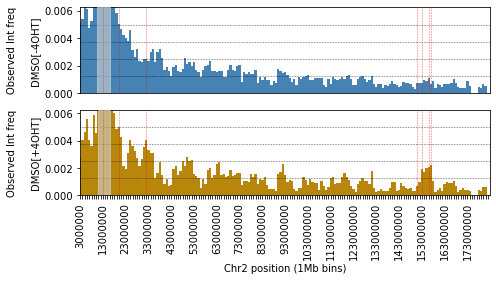

In [17]:
#Observed plots
c1=(rowsND['obsv'])
c1 = np.array(c1).ravel()
c1_df = pd.DataFrame()
c1_df['4C-interactions'] = c1.tolist()

c2=(rowsfoht['obsv'])
c2 = np.array(c2).ravel()
c2_df = pd.DataFrame()
c2_df['4C-interactions'] = c2.tolist()

#bin identities
bars=bins['start']
bars_df = pd.DataFrame(bars)
c1_df['bars']=bars.tolist()
c2_df['bars']=bars.tolist()


#key for reference lines
DSBs=[10,17,29,148,150,153,154]
ylines=[0.00125,0.0025,0.00375,0.005]
fig, (ax1, ax2) = plt.subplots(2,figsize=[7, 4])
#plot obsv/exp
ax1=c1_df.plot(x='bars', y='4C-interactions',kind='bar', color='steelblue',width=1,ax=ax1)
for xc in DSBs:
    ax1.axvline(x=xc, color='r', linewidth=0.6,linestyle=':',zorder=10)
ax1.axvspan(7.5, 13, color = "lightgrey", alpha=0.6,zorder=10)
for yc in ylines:
    ax1.axhline(y=yc, color='k', linewidth=0.6,linestyle=':',zorder=5)
ax1.set_ylim(0,0.00625)
ax1.set_xlim(0,)
ax1.set_ylabel("Observed Int freq\n\nDMSO[-4OHT]")
ax1.get_legend().remove()
ax1.set_xticks([]) 
ax1.xaxis.label.set_visible(False)
#plot obsverved
ax2=c2_df.plot(x='bars', y='4C-interactions',kind='bar', color='darkgoldenrod',width=1,ax=ax2)
for xc in DSBs:
    ax2.axvline(x=xc, color='r', linewidth=0.6,linestyle=':', zorder=10)        
ax2.axvspan(8, 13, color = "lightgrey", alpha=0.6, zorder=10)
for yc in ylines:
    ax2.axhline(y=yc, color='k', linewidth=0.6,linestyle=':',zorder=5)
ax2.set_xlabel("Chr2 position (1Mb bins)")
ax2.set_ylabel("Observed Int freq\n\nDMSO[+4OHT]")
ax2.set_ylim(0,0.00625)
ax2.set_xlim(0,)
ax2.get_legend().remove()
xticks = ax2.xaxis.get_major_ticks()
for i,tick in enumerate(xticks):
    if i%10 != 0:
        tick.label1.set_visible(False)
        
fig.tight_layout()
#plt.savefig('/*.pdf',dpi=300,bbox_inches='tight')


# Observed/Expected plots

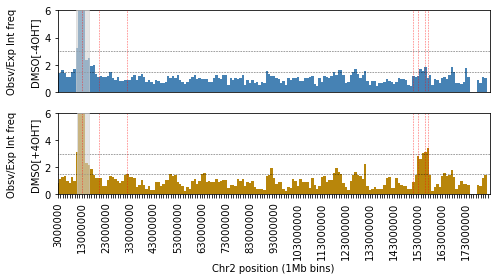

In [18]:
#Observed/Expected plots
c1=(rowsND['OvE'])
c1 = np.array(c1).ravel()
c1_df = pd.DataFrame()
c1_df['4C-interactions'] = c1.tolist()

c2=(rowsfoht['OvE'])
c2 = np.array(c2).ravel()
c2_df = pd.DataFrame()
c2_df['4C-interactions'] = c2.tolist()

bars=bins['start']
bars_df = pd.DataFrame(bars)
c1_df['bars']=bars.tolist()
c2_df['bars']=bars.tolist()

#key for reference lines
DSBs=[10,17,29,148,150,153,154]
ylines=[1.5,3]
fig, (ax1, ax2) = plt.subplots(2,figsize=[7, 4])

#plot obsv/exp
ax1=c1_df.plot(x='bars', y='4C-interactions',kind='bar', color='steelblue',width=1,ax=ax1)
for xc in DSBs:
    ax1.axvline(x=xc, color='r', linewidth=0.6,linestyle=':',zorder=10)
ax1.axvspan(7.5, 13, color = "lightgrey", alpha=0.6,zorder=10)
for yc in ylines:
    ax1.axhline(y=yc, color='k', linewidth=0.6,linestyle=':',zorder=5)
ax1.set_ylim(0,6)
ax1.set_xlim(0,)
ax1.set_ylabel("Obsv/Exp Int freq\n\nDMSO[-4OHT]")
ax1.get_legend().remove()
ax1.set_xticks([]) 
ax1.xaxis.label.set_visible(False)
#plot obsverved
ax2=c2_df.plot(x='bars', y='4C-interactions',kind='bar', color='darkgoldenrod',width=1,ax=ax2)
for xc in DSBs:
    ax2.axvline(x=xc, color='r', linewidth=0.6,linestyle=':', zorder=10)        
ax2.axvspan(8, 13, color = "lightgrey", alpha=0.6, zorder=10)
for yc in ylines:
    ax2.axhline(y=yc, color='k', linewidth=0.6,linestyle=':',zorder=5)
ax2.set_xlabel("Chr2 position (1Mb bins)")
ax2.set_ylabel("Obsv/Exp Int freq\n\nDMSO[+4OHT]")
ax2.set_ylim(0,6)
ax2.set_xlim(0,)
ax2.get_legend().remove()
xticks = ax2.xaxis.get_major_ticks()
for i,tick in enumerate(xticks):
    if i%10 != 0:
        tick.label1.set_visible(False)
        
fig.tight_layout()       
#plt.savefig('/*.pdf',dpi=300,bbox_inches='tight')


# Difference plots

/home/as38w/miniconda3/envs/coolerenv_manual_master/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


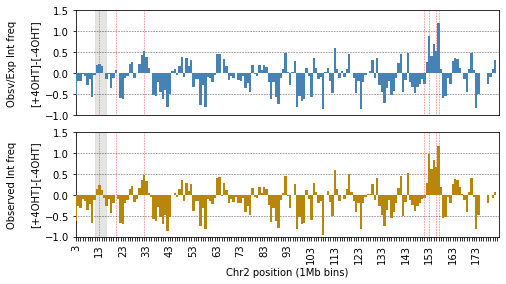

In [19]:
#difference 4OHT vs control: Observed and observed/expected

c1=(rowsND['OvE'])
c2=(rowsfoht['OvE'])
c1o=(rowsND['obsv'])
c2o=(rowsfoht['obsv'])

diff1=np.log(c2)-np.log(c1)
diff1 = np.array(diff1).ravel()
diff1_df = pd.DataFrame()
diff1_df['4C-interactions'] = diff1.tolist()

diff2=np.log(c2o)-np.log(c1o)
diff2 = np.array(diff2).ravel()
diff2_df = pd.DataFrame()
diff2_df['4C-interactions'] = diff2.tolist()

bars=bins['start']
bars_df = pd.DataFrame(bars)
diff1_df['bars']=bars.tolist()
diff1_df['bars']=(diff1_df['bars']/1000000).astype(int)
diff2_df['bars']=diff1_df['bars']

DSBs=[10,17,29,148,150,153,154]
ylines=[1,0.5,-0.5]

fig, (ax1, ax2) = plt.subplots(2,figsize=[7, 4])
diff1_df.plot(x='bars', y='4C-interactions',kind='bar', color='steelblue',zorder=10,width=1,ax=ax1)
for xc in DSBs:
    ax1.axvline(x=xc, color='r', linewidth=0.6,linestyle=':',zorder=5)
ax1.axvspan(8, 13, color = "lightgrey", alpha=0.6)
for yc in ylines:
    ax1.axhline(y=yc, color='k', linewidth=0.6,linestyle=':',zorder=5)
ax1.set_ylim(-1,1.5)
ax1.set_xlim(0,)
ax1.set_ylabel("Obsv/Exp Int freq\n\n[+4OHT]-[-4OHT]")
ax1.get_legend().remove()
ax1.set_xticks([]) 
ax1.xaxis.label.set_visible(False)

diff2_df.plot(x='bars', y='4C-interactions',kind='bar', color='darkgoldenrod',zorder=10,width=1,ax=ax2)
for xc in DSBs:
    ax2.axvline(x=xc, color='r', linewidth=0.6,linestyle=':', zorder=5)        
ax2.axvspan(8, 13, color = "lightgrey", alpha=0.6)
for yc in ylines:
    ax2.axhline(y=yc, color='k', linewidth=0.6,linestyle=':',zorder=5)
ax2.set_xlabel("Chr2 position (1Mb bins)")
ax2.set_ylabel("Observed Int freq\n\n[+4OHT]-[-4OHT]")
ax2.set_ylim(-1,1.5)
ax2.set_xlim(0,)
ax2.get_legend().remove()
xticks = ax2.xaxis.get_major_ticks()
for i,tick in enumerate(xticks):
    if i%10 != 0:
        tick.label1.set_visible(False)

fig.tight_layout()
#plt.savefig('/*diff.pdf',dpi=300,bbox_inches='tight')
